## Medical Report Generation using Deep Learning

**Introduction**
  - The automatic processing of radiological images and their associated free-text reports is one of the most
rapidly growing areas of Machine Learning for Healthcare. This is in part motivated by the tremendous
success ML has shown in other areas of computer vision, and in part by the large potential for ML-aided
assistive technologies within the clinical radiological workflow.
For less-experienced radiologists and pathologists, especially those working in the rural areas where the
quality of healthcare is relatively low, writing medical-imaging reports is demanding or on the other hand for
experienced radiologists and pathologists, writing imaging reports can be tedious and time consuming.
In this project, we focus on medical report generation from chest X-ray images using some latest
advancements in deep learning.
  - The Dataset used in this Notebook is Open- I dataset which contains 7470 X_Ray Images and 3955 reports in XML format.

### Reading Required Libraries

In [ ]:
pip install pycocoevalcap

     |████████████████████████████████| 104.3 MB 43 kB/s 


In [ ]:
pip install -U nltk

     |████████████████████████████████| 1.5 MB 5.3 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
from google.colab import drive
import os
from cv2 import imread,resize,IMREAD_COLOR
import numpy as np
import pandas as pd
import tqdm
import string
import re
from joblib import dump, load
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
import sys
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
## FLAGS
REPS_FLAG = False

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# base_path = '/content/gdrive/MyDrive/Image_captioning_capstone'
base_path = '/content/gdrive/My Drive/Colab Notebooks/Image_captioning_capstone'

In [ ]:
csv_list = os.listdir(base_path + '/CSV Files')
print(csv_list)

['lateral_dataset.csv', 'lateral_dataset.xlsx', 'Lateral_XRay_Images.csv', 'cross_sectional_dataset.csv', 'X_ray_annotations.csv', 'Cross_Sectional_XRay_Images.csv']


In [ ]:
csv_list[0]

'lateral_dataset.csv'

### Reading Required CSV Files

In [ ]:
lateral_dataset = pd.read_csv(base_path + '/CSV Files/lateral_dataset.csv')
frontal_dataset = pd.read_csv(base_path + '/CSV Files/cross_sectional_dataset.csv')

In [ ]:
lateral_dataset.head()

,Unnamed: 0,File_Name,Key,Label,Num X_rays,Comparison,Indication,Findings,Impression
0,0,CXR1840_IM-0545-2001.png,1840,1840.xml,2,None,XXXX left chest pain,PA and lateral views of the chest were obtaine...,"1. Asymmetric left suprahilar opacity, conside..."
1,1,CXR2722_IM-1184-2001.png,2722,2722.xml,2,XXXX,SOB,Overall low lung volumes. Lungs are grossly cl...,1. Cardiomegaly. 2. Pleural thickening along t...
2,2,CXR2062_IM-0699-0001-0002.png,2062,2062.xml,2,NaN,The patient is a XXXX-year-old male admitted f...,"Right subclavian catheter, distal tip posterio...","1. Right subclavian catheter, distal tip in th..."
3,3,CXR2715_IM-1180-2001.png,2715,2715.xml,2,Chest x-XXXX XXXX XXXX,ECF placement,Heart size and mediastinal contour are normal....,1. Right lower lobe pulmonary nodule. XXXX for...
4,4,CXR135_IM-0227-3003.png,135,135.xml,2,None,Chest pain,The lungs are grossly clear without focal pneu...,Clear lungs


In [ ]:
frontal_dataset.head()

,Unnamed: 0,File_Name,Key,Label,Num X_rays,Comparison,Indication,Findings,Impression
0,0,CXR964_IM-2454-1001.png,964,964.xml,2,NaN,NaN,"In the interval, the heart size has become nor...",Resolution of cardiomegaly. No active disease.
1,1,CXR261_IM-1100-1001.png,261,261.xml,3,Chest x-XXXX dated XXXX.,"XXXX-year-old male, dyspnea.",No focal areas of consolidation. Heart size wi...,No acute cardiopulmonary abnormality. .
2,2,CXR261_IM-1100-12012.png,261,261.xml,3,Chest x-XXXX dated XXXX.,"XXXX-year-old male, dyspnea.",No focal areas of consolidation. Heart size wi...,No acute cardiopulmonary abnormality. .
3,3,CXR3607_IM-1781-1001.png,3607,3607.xml,1,None.,Bone marrow transplant workup.,Heart size and pulmonary vascularity appear wi...,"1. XXXX opacities in the left base, the appear..."
4,4,CXR2006_IM-0656-1001.png,2006,2006.xml,2,Two views of the chest dated XXXX.,XXXX-year-old with chest pain this XXXX.,Heart size is mildly enlarged. The pulmonary X...,Cardiomegaly without superimposed acute diseas...


In [ ]:
lateral_dataset = lateral_dataset.drop(['Unnamed: 0','Label','Num X_rays','Comparison','Indication','Impression'],axis=1)
frontal_dataset = frontal_dataset.drop(['Unnamed: 0','Label','Num X_rays','Comparison','Indication','Impression'],axis=1)

In [ ]:
lateral_dataset.head()

,File_Name,Key,Findings
0,CXR1840_IM-0545-2001.png,1840,PA and lateral views of the chest were obtaine...
1,CXR2722_IM-1184-2001.png,2722,Overall low lung volumes. Lungs are grossly cl...
2,CXR2062_IM-0699-0001-0002.png,2062,"Right subclavian catheter, distal tip posterio..."
3,CXR2715_IM-1180-2001.png,2715,Heart size and mediastinal contour are normal....
4,CXR135_IM-0227-3003.png,135,The lungs are grossly clear without focal pneu...


Creating report_df to proceed further with the modelling. We can easily switch between lateral and frontal images for analysis

In [ ]:
report_df = frontal_dataset

In [ ]:
report_df['Findings'] = report_df['Findings'].astype('string')

In [ ]:
report_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3727 entries, 0 to 3726
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File_Name  3727 non-null   object
 1   Key        3727 non-null   int64 
 2   Findings   3231 non-null   string
dtypes: int64(1), object(1), string(1)
memory usage: 87.5+ KB


In [ ]:
report_df = report_df.dropna(axis=0)
report_df = report_df.reset_index(drop=True)

### Exploratory Data Analysis
This Block shows basic information about the caption part of the Dataset such as
* The Maximum and Minimum Length Captions
* The Graph of length of captions vs number of captions
* The Word Count of all unique words in all captions

In [ ]:
length = []
report_df['Findings'].apply(lambda text : length.append(len(str(text).split(' '))))
print('The Maximum Sequence Length is ' + str(max(length)))
print('The Minimum Sequence Length is ' + str(min(length)))
max_len = max(length)
min_len = min(length)

The Maximum Sequence Length is 173
The Minimum Sequence Length is 7


In [ ]:
max_cpt = np.where(np.array(length) == max_len)
min_cpt = np.where(np.array(length) == min_len)
print('The Maximum Length Caption is \n' + str(report_df['Findings'][max_cpt[0][0]]))
print('')
print('The Minimum Length Caption is \n' + str(report_df['Findings'][min_cpt[0][0]]))

The Maximum Length Caption is 
Chest  Comparison: There is a 2.6 cm diameter masslike density over the lingula partial obscuration left cardiac XXXX. There may be some ill-defined opacity in the right mid and lower lung zone. No pleural effusion is seen. The heart is borderline enlarged. The aorta is dilated and tortuous. Arthritic changes of the spine are present.  Pelvis and left hip There is an impacted and rotated fracture through the neck of the femur on the left. No pelvic fracture is seen. Arthritic changes are present in the lower lumbar spine. Large amount of stool and XXXX obscures portions of the pelvis.  Femur The femoral images do not XXXX the area of the hip fracture. The remaining portions of the femur appear to be intact with no fracture or destructive process. Extensive atherosclerotic vascular disease throughout the superficial femoral artery is present.  Left knee There is osteoporosis and mild arthritic changes. No fracture is seen. No dislocation is identified. Sev

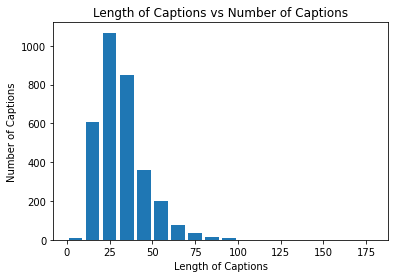

In [ ]:
bins = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180]
plt.hist(length, bins, histtype='bar', rwidth=0.8)
plt.xlabel('Length of Captions')
plt.ylabel('Number of Captions')
plt.title('Length of Captions vs Number of Captions')
plt.show()

In [ ]:
def word_count(texts):
  word_cnt = {}
  for text in texts:
    if text is None:
      continue
    if  'NAType' in str(type(text)):
      continue
    words = text.split(" ")
    for word in words:
      try:
        word_cnt[word] += 1
      except:
        word_cnt[word] = 1
  return word_cnt

word_cnt = word_count(report_df['Findings'])
print('The Number of Unique Words is ' + str(len(word_cnt)))
for key, value in word_cnt.items():
  print(key + ' --> ' + str(value))

The Number of Unique Words is 2661
In --> 30
the --> 2559
interval, --> 13
heart --> 992
size --> 1435
has --> 75
become --> 1
normal. --> 1140
Pulmonary --> 202
XXXX --> 1867
are --> 4131
Lungs --> 468
clear --> 515
and --> 2627
expanded. --> 113
No --> 2824
focal --> 1671
areas --> 112
of --> 2308
consolidation. --> 381
Heart --> 985
within --> 1445
normal --> 1881
limits. --> 1024
pleural --> 2342
effusions. --> 161
evidence --> 334
pneumothorax. --> 1092
Osseous --> 86
structures --> 548
appear --> 393
intact. --> 328
pulmonary --> 919
vascularity --> 330
The --> 3355
patient --> 62
is --> 4054
status --> 11
post --> 19
CABG. --> 19
A --> 56
few --> 10
opacities --> 146
present --> 139
in --> 1304
left --> 601
base, --> 11
appearance --> 45
which --> 101
scarring --> 77
or --> 2298
atelectasis. --> 103
pneumothorax --> 820
effusion --> 746
seen. --> 288
Degenerative --> 152
changes --> 516
spine. --> 433
mildly --> 98
enlarged. --> 105
mediastinum --> 512
There --> 2136
no --> 1399

### Data Pre-Processing

The Purpose of this block is to perform the tasks of data cleaning and data preprocessing.  
The Tasks performed are :-
1. Transform upper-case characters to lower-case characters
2. Remove punctuations from the captions.
3. Remove redactions from the captions
4. Add <start> token and <end> token to each caption to the start and end of the caption respectively

In [ ]:
report_df['Findings'] = report_df['Findings'].str.lower()

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def remove_punctuations(text):
  for punctuation in string.punctuation:
    if punctuation == '.':
      text = str(text)
      text = text.replace(punctuation, ' .')
    else:
      text = str(text)
      text = text.replace(punctuation, '')
  return text

report_df['Findings'] = report_df['Findings'].apply(remove_punctuations)

In [ ]:
report_df['Findings'].head()

0    in the interval the heart size has become norm...
1    no focal areas of consolidation . heart size w...
2    no focal areas of consolidation . heart size w...
3    heart size and pulmonary vascularity appear wi...
4    heart size is mildly enlarged . the pulmonary ...
Name: Findings, dtype: object

#### Finding the words with xxxx
Finding the words with xxxx before removing the words with xxxx to ensure not to remove any important terms


In [ ]:
def words_XXXX(text):
  words = []
  for w in text.split(" "):
    if w.find('xxxx') >= 0:
      w = w.replace('xxxx', '')
      if len(w.strip()) > 0:
        words.append(w)
  finding = " ".join(words)
  if len(finding.strip()) == 0:
    return None
  return finding

words_with_xxxx = report_df['Findings'].apply(words_XXXX)

In [ ]:
words_with_xxxx.dropna(inplace=True)

In [ ]:
words_with_xxxx

100              a
101              a
262              4
428     granulomas
679            x x
964              a
1043             t
1059             a
1506    granulomas
1706             a
1723        filled
1870             a
2064        ofview
2238             x
2273            ct
2433          3rd5
2459             a
2495             x
2666             a
2868             a
2901             t
2930         fluid
2954        filled
2974        ofview
3000         02010
Name: Findings, dtype: object

In [ ]:
report_df.loc[1506,["Findings"]][0]

'the cardiomediastinal silhouette is normal in size and contour . calcified left hilar lymph xxxxgranulomas . no focal consolidation pneumothorax or large pleural effusion . old fracture right mid clavicle .'

Words like 'granulomas', 'filled' etc listed below in important_words_withxxxx needs to be separated out from 'xxxx' and retained.

In [ ]:
important_words_withxxxx = ['granulomas', 'filled', 'ofview', 'ct', 'in', 'fluid', 'filled', 'ofview']

In [ ]:
def remove_XXXX(text):
  words = []
  for w in text.split(" "):
    if w.find('xxxx') >= 0:
      # Words with 'xxxx' will be removed here. Some important words will be retained.
      for iw in important_words_withxxxx:
        if iw in w:
          words.append(iw)
    else:
      words.append(w)
  finding = " ".join(words)
  if len(finding.strip()) == 0:
    return None
  return finding

report_df['Findings'] = report_df['Findings'].apply(remove_XXXX)

#### Removing Number and adding start and end

In [ ]:
def remove_numbers(text):
  words = []
  for w in text.split(" "):
    if w == '.' or w.isalpha():
      words.append(w)

  finding = " ".join(words)
  return finding

report_df['Findings'] = report_df['Findings'].apply(remove_numbers)

In [ ]:
report_df.loc[1506,["Findings"]][0]

'the cardiomediastinal silhouette is normal in size and contour . calcified left hilar lymph granulomas . no focal consolidation pneumothorax or large pleural effusion . old fracture right mid clavicle .'

In [ ]:
def adding_Tokens(text):
    return '<start> ' + text + ' <end>'

report_df['Findings'] = report_df['Findings'].apply(adding_Tokens)

In [ ]:
report_df.loc[1506, 'Findings']

'<start> the cardiomediastinal silhouette is normal in size and contour . calcified left hilar lymph granulomas . no focal consolidation pneumothorax or large pleural effusion . old fracture right mid clavicle . <end>'

In [ ]:
length = []
report_df['Findings'].apply(lambda text : length.append(len(str(text).split(' '))))
# max_len = max(length)

0       None
1       None
2       None
3       None
4       None
        ... 
3226    None
3227    None
3228    None
3229    None
3230    None
Name: Findings, Length: 3231, dtype: object

In [ ]:
findings = report_df['Findings']

In [ ]:
report_df.head(25)

,File_Name,Key,Findings
0,CXR964_IM-2454-1001.png,964,<start> in the interval the heart size has bec...
1,CXR261_IM-1100-1001.png,261,<start> no focal areas of consolidation . hear...
2,CXR261_IM-1100-12012.png,261,<start> no focal areas of consolidation . hear...
3,CXR3607_IM-1781-1001.png,3607,<start> heart size and pulmonary vascularity a...
4,CXR2006_IM-0656-1001.png,2006,<start> heart size is mildly enlarged . the pu...
5,CXR3750_IM-1874-1001.png,3750,<start> there is stable cardiomegaly . right p...
6,CXR1412_IM-0262-1001.png,1412,<start> the lungs are clear . the heart and pu...
7,CXR1360_IM-0234-0001-0001.png,1360,<start> there are opacities within both lung b...
8,CXR2836_IM-1252-1001.png,2836,<start> frontal and lateral views of the chest...
9,CXR3586_IM-1764-1001.png,3586,<start> the heart is mildly enlarged . the med...


### Word Tokenizer
This Block instantiates the tokenizer object for two main goals.  
1. To transform the text to a tokenized representation.
2. To create the word-to-index and index-to-word dictionaries for transforming to and from tokenized representation

In [ ]:
REPS_FLAG=False

In [ ]:
token = None
if REPS_FLAG==True:
  # '.' character has been removed from the filters as '.' will be treated as a separate word
  token = Tokenizer(num_words = 5000, filters='!"#$%&()*+,-/:;=?@[\]^_`{|}~')
  token.fit_on_texts(report_df['Findings'])
  dump(token, base_path + '/Image_Representations/token.joblib')
else:
  token = load(base_path + '/Image_Representations/token.joblib')


In [ ]:
print("Number of words in the tokenizer's index is " + str(len(token.word_index)))

Number of words in the tokenizer's index is 1563


### Downloading GloVE Representations for Embedding Matrix
This Block downloads the GloVe Representations of Words which is to be used as embeddings for the model

In [ ]:
#  !wget http://nlp.stanford.edu/data/glove.6B.zip
#  !unzip -a glove.6B.zip
!wget https://nlp.stanford.edu/data/glove.42B.300d.zip
!unzip -a glove.42B.300d.zip

--2021-09-05 05:52:23--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2021-09-05 05:52:23--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Saving to: ‘glove.42B.300d.zip’

glove.42B.300d.zip   17%[==>                 ] 310.01M  5.00MB/s    eta 4m 33s ^C
Archive:  glove.42B.300d.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archiv

In [ ]:
REPS_FLAG

False

In [ ]:
embeddings_index = {}
embedding_dim = 300

if REPS_FLAG==True:
  # f = open('glove.6B.200d.txt', encoding="utf-8")
  f = open('glove.42B.300d.txt', encoding="utf-8")
  for line in tqdm.tqdm(f):
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  vocab_size = len(token.word_index) + 1
  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  for word, key in token.word_index.items():
      if word in embeddings_index.keys():
          embedding_matrix[key] = embeddings_index[word]
  dump(embedding_matrix, base_path + '/Image_Representations/embedding_matrix_attn.joblib')

else:
  embedding_matrix = load(base_path + '/Image_Representations/embedding_matrix_attn.joblib')

In [ ]:
vocab_size = len(token.word_index) + 1

In [ ]:
# REPS_FLAG=False

### Getting Image Representations
The Tasks performed by this Block are:-
* This Block downloads the InceptionV3 model to convert the images to their respective representations.  
* This Block resizes the image according to the input_shape specified by the InceptionV3 Model, obtains the image representations for all images and finally splits the image representation into train and test set
* The train and test data are dumped into drive / disk. This can be done once. In the remaining iterations, it can be loaded back into the respective Train and Test variables used.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import preprocess_input, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten

In [ ]:
# Image chosen as 288 to have (9, 9, 1024) in the output of Chexnet model
IMG_SIZE = 224
IMG_CHANNELS = 3
POOLED_OUTPUT_SIZE = 1024
chexnet_weights_path = base_path + "/CheXnet/brucechou1983_CheXNet_Keras_0.3.0_weights.h5"
FAST_RUN = False # use only a few rows, for fast debugging
FAST_RUN_SAMPLES = 150 # num rows to use from train, test when in fast_mode

In [ ]:
densenet_model = DenseNet121(weights=None,
                            include_top=False,
                            input_shape=(IMG_SIZE,IMG_SIZE,IMG_CHANNELS))
# adding a dummy layer to load the weights
dummy_layer = Dense(14, activation='sigmoid', name='predictions')(densenet_model.output)
densenet_model = tf.keras.Model(inputs=densenet_model.input, outputs=dummy_layer)
densenet_model.load_weights(chexnet_weights_path)
densenet_model.trainable=False # freeze most layers
densenet_model.training=False

# getting the output of the previous layer as
chexnet_model = Model(densenet_model.input, densenet_model.layers[-2].output)

# Global average pooling to reduce the size of the output
# global_avg_pooling = GlobalAveragePooling2D()(densenet_model.layers[-4].output)
# chexnet_model = Model(densenet_model.input, global_avg_pooling)

# Flatten Features
# Flatten_features = Flatten()(densenet_model.layers[-2].output)
# chexnet_model = Model(densenet_model.input, Flatten_features)

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
chexnet_model.layers[-1]

In [ ]:
chexnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.790958 to fit



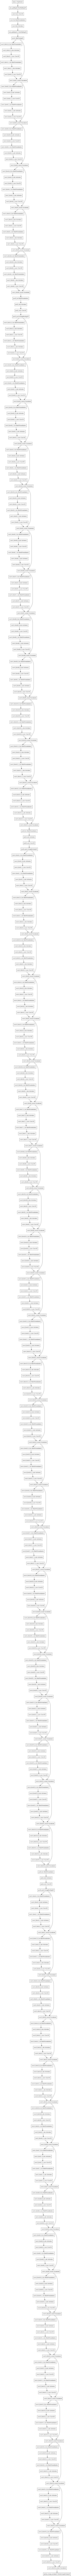

In [ ]:
plot_model(chexnet_model)

In [ ]:
chexnet_model.input

<KerasTensor: shape=(None, 288, 288, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
from PIL import Image
from skimage.transform import resize

In [ ]:
def read_images(image_set):
  image_reps = {}
  for image in tqdm.tqdm(image_set):
    image_data = Image.open(base_path + '/Images/' + image)
    if image_data is None:
      pass
    else:
      image_data = np.asarray(image_data.convert("RGB"))
      image_data = np.asarray(image_data)
      image_data = preprocess_input(image_data)
      resized_image = np.array(resize(image_data, (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)))
      image_features = chexnet_model.predict(resized_image.reshape(1,IMG_SIZE, IMG_SIZE, IMG_CHANNELS))
      image_features = np.expand_dims(image_features, axis=0)
      image_features = np.asarray(image_features)
      image_reps[image] = image_features
  return image_reps

In [ ]:
REPS_FLAG

False

In [ ]:
X_train_names = None
X_test_names = None
y_train = None
y_test = None
X_train = None
X_test = None
# REPS_FLAG = True

if (REPS_FLAG == True):
  # Dividing the data into Train and Test sets and dumping them into drive
  # X_train_names, X_test_names, y_train, y_test = train_test_split(report_df['File_Name'], report_df['Findings'], test_size=0.2, random_state = 42)
  X_train_names = load(base_path + '/Image_Representations/X_train_names.joblib')
  X_test_names = load(base_path + '/Image_Representations/X_test_names.joblib')
  images = [X_train_names, X_test_names]
  print('Getting Image Representation for Train Set')
  X_train = read_images(images[0])
  print('Getting Image Representation for Test Set')
  X_test = read_images(images[1])
  dump(X_train,base_path + '/Image_Representations/X_train_chexnet_attn.joblib')
  dump(X_test,base_path + '/Image_Representations/X_test_chexnet_attn.joblib')
  y_train = load(base_path + '/Image_Representations/y_train.joblib')
  y_test = load(base_path + '/Image_Representations/y_test.joblib')
else:
  # Loading the Train and Test sets from drive
  print("Reading train set and test set from Folder")
  X_train = load(base_path + '/Image_Representations/X_train_chexnet_attn.joblib')
  X_test = load(base_path + '/Image_Representations/X_test_chexnet_attn.joblib')
  y_train = load(base_path + '/Image_Representations/y_train_with_fullstops.joblib')
  y_test = load(base_path + '/Image_Representations/y_test_with_fullstops.joblib')
  X_train_names = load(base_path + '/Image_Representations/X_train_names.joblib')
  X_test_names = load(base_path + '/Image_Representations/X_test_names.joblib')
  images = [X_train_names, X_test_names]

REPS_FLAG = False


Reading train set and test set from Folder


In [ ]:
finding_series = report_df[report_df['File_Name'] == 'CXR3618_IM-1790-82420001.png']['Findings']
finding_series.loc[finding_series.index[0]]

'<start> the heart size and mediastinal silhouette are within normal limits . no pneumothorax or pleural effusions . the lungs are clear . no focal consolidations . the osseous structures are intact . <end>'

In [ ]:
# Building y_train and y_test with 'dots'
if REPS_FLAG == True:
  # y_train
  findings = []
  indices = []
  for idx in X_train_names.index:
    img_name = X_train_names.loc[idx]
    finding_series = report_df[report_df['File_Name'] == img_name]['Findings']
    finding = finding_series.loc[finding_series.index[0]]
    findings.append(finding)
    indices.append(idx)

  y_train = pd.Series(findings, index=indices, name='TrainFindings')

  # y_test
  findings = []
  indices = []
  for idx in X_test_names.index:
    img_name = X_test_names.loc[idx]
    finding_series = report_df[report_df['File_Name'] == img_name]['Findings']
    finding = finding_series.loc[finding_series.index[0]]
    findings.append(finding)
    indices.append(idx)

  y_test = pd.Series(findings, index=indices, name='TestFindings')

  dump(y_train,base_path + '/Image_Representations/y_train_with_fullstops.joblib')
  dump(y_test,base_path + '/Image_Representations/y_test_with_fullstops.joblib')

In [ ]:
y_train[937]

'<start> the heart size and mediastinal silhouette are within normal limits . no pneumothorax or pleural effusions . the lungs are clear . no focal consolidations . the osseous structures are intact . <end>'

In [ ]:
length = []
for idx in y_train.index:
  length.append(len(y_train[idx].split(" ")))
for idx in y_test.index:
  length.append(len(y_test[idx].split(" ")))
max_len = max(length)

In [ ]:
print(max_len)

184


### Data Generator for Model
The Tasks performed by this Block are:-
* This Block defines the DataGenerator Class for the purpose of data ingestion for the model.  
* The Object of this Class generates a batch of data, i.e the image representation along with the corresponding input sequence and actual output sequence.

In [ ]:
class DataGenerator(Sequence):
  def __init__(self,data,token,max_length,batch_size,shuffle):
    self.data = list(data)
    self.token = token
    self.max_length = max_length
    self.batch_size = batch_size
    self.list_IDs = np.arange(len(self.data))
    self.indexes = self.list_IDs
    self.shuffle = shuffle

  def on_epoch_end(self):
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __len__(self):
    return int(np.floor(len(self.data)/self.batch_size))

  def __getitem__(self, index):
    index = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.list_IDs[k] for k in index]
    X,y = self.__data_generation(list_IDs_temp)
    return X,y

  def __data_generation(self,list_IDs_temp):
    X1, X2, y = list(), list(), list()
    for id in list_IDs_temp:
        seq = token.texts_to_sequences(self.data[id][1:])[0]
        in_seq = pad_sequences([seq], maxlen=self.max_length, padding='post')[0]
        X1.append(self.data[id][0])
        y.append(in_seq)

    return np.array(X1), np.array(y)
    # return [np.array(X1),np.array(X2)],np.array(y)

Creating the train data for data generator

In [ ]:
train_image_data = list(X_train.values())
for i in range(len(train_image_data)):
  train_image_data[i] = tf.reshape(train_image_data[i], (49,1024))

In [ ]:
test_image_data = list(X_test.values())
for i in range(len(test_image_data)):
  test_image_data[i] = tf.reshape(test_image_data[i], (49,1024))

In [ ]:
train_captions = y_train
train_data = np.array(list(zip(train_image_data,train_captions)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


Creating the test data for data generator

In [ ]:
test_captions = y_test
test_data = np.array(list(zip(test_image_data,test_captions)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
datagen_demo = DataGenerator(train_data,token,max_length=max_len,batch_size=1,shuffle=False)
X,y = datagen_demo.__getitem__(0)
# print("The First Input Sequence is " + str(X[1][0]))
print('The Shape of Input Sequence is ' + str(X.shape))
# print("The Output is " + str(y[0]))
print('The Shape of Output Sequence is ' + str(y.shape))

The Shape of Input Sequence is (1, 49, 1024)
The Shape of Output Sequence is (1, 184)


### Defining the Model
This Block defines the Model Architecture, and trains the model on the specified loss and optimizer parameters.

Function to Plot the model Training loss

In [ ]:
def plotHistory(history):
  # summarize history for accuracy
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()

### Model with One LSTM

In [ ]:
# def convert(images, reports):
#     '''This function takes the batch of data and converts them into a new dataset(A WORD BY WORD DATASET)'''
#     imgs = []
#     in_reports = []
#     out_reports = []
#     for i in range(len(images)):
#         sequence = [token.word_index[e] for e in reports[i].split() if e in token.word_index.keys()]
#         for j in range(1,len(sequence)):

#             in_seq = sequence[:j]
#             out_seq = sequence[j]
#             out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

#             imgs.append(images[i])
#             in_reports.append(in_seq)
#             out_reports.append(out_seq)
#     return np.array(imgs), np.array(in_reports), np.array(out_reports)

In [ ]:
# token.word_index.keys()

In [ ]:
# train_captions.index[0]

In [ ]:
# len(train_image_data)

In [ ]:
# train_data_with_seq = convert(train_image_data, train_captions)
# test_data_with_seq = convert(test_image_data, test_captions)

In [ ]:
# Logic for loss calculation by masking the 0's present in the sequence.
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='auto')

def maskedLoss(y_true, y_pred):
  #getting mask value
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))

  #calculating the loss
  loss_ = loss_function(y_true, y_pred)

  #converting mask dtype to loss_ dtype
  mask = tf.cast(mask, dtype=loss_.dtype)

  #applying the mask to loss
  loss_ = loss_*mask

  #getting mean over all the values
  loss_ = tf.reduce_mean(loss_)
  return loss_

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Encoder, self).__init__()
        self.units = units
       # self.bs = batch_size

    def build(self, input_shape):
        self.maxpool = tf.keras.layers.MaxPool1D()
        self.dense = Dense(self.units, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')

    def call(self, input_, training=True):

        x = self.maxpool(input_)
        x = self.dense(x)

        return x

    def get_states(self, bs):

        return tf.zeros((bs, self.units))

In [ ]:
from tensorflow.keras.layers import GRU

In [ ]:
class OneStepDecoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, att_units, dec_units):
        super(OneStepDecoder, self).__init__()
        self.vocab_size = vocab_size
       # self.emb_dim = emb_dim
        self.att_units = att_units
        self.dec_units = dec_units

    def build(self, input_shape):
        self.embedding = Embedding(self.vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True,
                                   weights = [embedding_matrix],
                                   name="embedding_layer_decoder")
        self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, name="Decoder_GRU")
        self.fc = Dense(self.vocab_size)

        self.V = Dense(1)
        self.W = Dense(self.att_units)
        self.U = Dense(self.att_units)

    def call(self, dec_input, hidden_state, enc_output):


        hidden_with_time = tf.expand_dims(hidden_state, 1)
        attention_weights = self.V(tf.nn.tanh(self.U(enc_output) + self.W(hidden_with_time)))
        attention_weights = tf.nn.softmax(attention_weights, 1)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)


        x = self.embedding(dec_input)
        x = tf.concat([tf.expand_dims(context_vector, axis=1),x], axis=-1)
        output, h_state = self.gru(x, initial_state = hidden_state)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, h_state, attention_weights

In [ ]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, vocab_size, input_length, dec_units, att_units):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        # self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.att_units = att_units
        self.onestep_decoder = OneStepDecoder(self.vocab_size, self.att_units, self.dec_units)
    @tf.function
    def call(self, dec_input, hidden_state, enc_output):
        all_outputs = tf.TensorArray(tf.float32, dec_input.shape[1], name='output_arrays')

        for timestep in range(dec_input.shape[1]):

            output, hidden_state, attention_weights = self.onestep_decoder(dec_input[:, timestep:timestep+1],
                                                                           hidden_state, enc_output)

            all_outputs = all_outputs.write(timestep, output)

        all_outputs = tf.transpose(all_outputs.stack(), [1,0,2])
        return all_outputs

In [ ]:
class Attention_Model(tf.keras.Model):
    def __init__(self, vocab, units, max_capt_len, att_units, batch_size):
        super(Attention_Model, self).__init__()
        self.batch_size = batch_size
        self.encoder = Encoder(units)
        self.decoder = Decoder(vocab_size, max_capt_len, units, att_units)

    def call(self, data):
        enc_input, dec_input = data[0], data[1]

        enc_output = self.encoder(enc_input)
        enc_state = self.encoder.get_states(self.batch_size)
        dec_output = self.decoder(dec_input, enc_state, enc_output)

        return dec_output

In [ ]:
units = 256
att_units = 10
BATCH_SIZE = 7
BUFFER_SIZE = 500

In [ ]:
embedding_dim, max_len

(300, 184)

In [ ]:
model = Attention_Model(vocab_size, units, max_len, att_units, BATCH_SIZE)

In [ ]:
train_datagen = DataGenerator(train_data,token,max_length=max_len,batch_size=BATCH_SIZE,shuffle=False)
test_datagen = DataGenerator(test_data,token,max_length=max_len,batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
import datetime

In [ ]:
EPOCHS = 15
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'Tensorboard/attention_OneStep/fit2/' + current_time + '/train'
val_log_dir = 'Tensorboard/attention_OneStep/fit2/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=maskedLoss,optimizer=optimizer,metrics=['accuracy'])

In [ ]:
import time

In [ ]:
epoch_train_loss = []
epoch_val_loss = []
epoch_train_accuracy = []
epoch_val_accuracy = []

for epoch in range(EPOCHS):
    start = time.time()
    print("EPOCH: ", epoch+1)
    batch_loss_tr = 0
    batch_loss_val = 0
    batch_accuracy_tr = 0
    batch_accuracy_val = 0
    print('Training...')
    for X, y in tqdm.tqdm(train_datagen):
        res = model.train_on_batch([X, y[:,:-1]], y[:,1:])
        # print('y_true shape: {}'.format(y.shape))
        # print('X1 shape: {}'.format(X.shape))
        # res = model.train_on_batch(X, y)
        batch_loss_tr += res[0]
        batch_accuracy_tr += res[1]
    train_loss = batch_loss_tr/(len(train_image_data)/BATCH_SIZE)
    train_accuracy = batch_accuracy_tr/(len(train_image_data)/BATCH_SIZE)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step = epoch)
        tf.summary.scalar('accuracy', train_accuracy, step = epoch)
    # print('Training Loss: {}'.format(train_loss))
    # break
    print("VALIDATING..")
    for X, y in tqdm.tqdm(test_datagen):
        # img = X[0]
        # rep = X[1]
        res = model.test_on_batch([X, y[:,:-1]], y[:,1:])
        # res = model.test_on_batch(X, y)
        batch_loss_val += res[0]
        batch_accuracy_val += res[1]

    val_loss = batch_loss_val/(len(test_image_data)/BATCH_SIZE)
    val_accuracy = batch_accuracy_val/(len(test_image_data)/BATCH_SIZE)
    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step = epoch)
        tf.summary.scalar('accuracy', val_accuracy, step = epoch)

    epoch_train_accuracy.append(train_accuracy)
    epoch_train_loss.append(train_loss)

    epoch_val_accuracy.append(val_accuracy)
    epoch_val_loss.append(val_loss)

    print('Training Loss: {},  Training accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'.format(train_loss, train_accuracy, val_loss, val_accuracy))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))
    model.save_weights(base_path + '/model/epoch_'+ str(epoch+1) + '.h5')

EPOCH:  1
Training...


100%|██████████| 369/369 [04:21<00:00,  1.41it/s]


VALIDATING..


100%|██████████| 92/92 [00:30<00:00,  3.01it/s]


Training Loss: 0.19270249279273596,  Training accuracy: 0.8320539173419261, Validation Loss: 0.13839224421950358, Validation Accuracy: 0.8629994668768952
Time Taken for this Epoch : 292.10472416877747 sec
EPOCH:  2
Training...


100%|██████████| 369/369 [01:33<00:00,  3.96it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  8.74it/s]


Training Loss: 0.1319873945747182,  Training accuracy: 0.8757570761460637, Validation Loss: 0.11330816948892897, Validation Accuracy: 0.8842746241383795
Time Taken for this Epoch : 103.71844410896301 sec
EPOCH:  3
Training...


100%|██████████| 369/369 [01:34<00:00,  3.92it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  8.67it/s]


Training Loss: 0.11204769845544461,  Training accuracy: 0.8904143198401935, Validation Loss: 0.09984338360693208, Validation Accuracy: 0.893886032944669
Time Taken for this Epoch : 104.74995040893555 sec
EPOCH:  4
Training...


100%|██████████| 369/369 [01:33<00:00,  3.93it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  8.79it/s]


Training Loss: 0.09782879275699426,  Training accuracy: 0.9002732238025857, Validation Loss: 0.0879744535464638, Validation Accuracy: 0.903041357603471
Time Taken for this Epoch : 104.32192873954773 sec
EPOCH:  5
Training...


100%|██████████| 369/369 [01:33<00:00,  3.94it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  8.99it/s]


Training Loss: 0.08555979382797452,  Training accuracy: 0.90939831426915, Validation Loss: 0.07907900180800068, Validation Accuracy: 0.91024569142178
Time Taken for this Epoch : 103.85491251945496 sec
EPOCH:  6
Training...


100%|██████████| 369/369 [01:33<00:00,  3.93it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  8.77it/s]


Training Loss: 0.0755791552609911,  Training accuracy: 0.9179947212476848, Validation Loss: 0.07255425231338376, Validation Accuracy: 0.9169094840746943
Time Taken for this Epoch : 104.4866316318512 sec
EPOCH:  7
Training...


100%|██████████| 369/369 [01:33<00:00,  3.95it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  8.89it/s]


Training Loss: 0.06775991326477666,  Training accuracy: 0.9245546357043017, Validation Loss: 0.06821455987000484, Validation Accuracy: 0.9214955942339653
Time Taken for this Epoch : 103.89979124069214 sec
EPOCH:  8
Training...


100%|██████████| 369/369 [01:33<00:00,  3.94it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  8.76it/s]


Training Loss: 0.06126225454842343,  Training accuracy: 0.9301100491600878, Validation Loss: 0.06501053186735192, Validation Accuracy: 0.9247810391038426
Time Taken for this Epoch : 104.25754237174988 sec
EPOCH:  9
Training...


100%|██████████| 369/369 [01:33<00:00,  3.94it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  8.88it/s]


Training Loss: 0.055297073856249865,  Training accuracy: 0.9351981089164967, Validation Loss: 0.06263590392180167, Validation Accuracy: 0.9281002694893473
Time Taken for this Epoch : 104.04766392707825 sec
EPOCH:  10
Training...


100%|██████████| 369/369 [01:33<00:00,  3.94it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  9.19it/s]


Training Loss: 0.04982277247643865,  Training accuracy: 0.9405568516568134, Validation Loss: 0.06138347562005199, Validation Accuracy: 0.9302793053055104
Time Taken for this Epoch : 103.77478814125061 sec
EPOCH:  11
Training...


100%|██████████| 369/369 [01:33<00:00,  3.93it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  8.78it/s]


Training Loss: 0.04504885206874114,  Training accuracy: 0.9452431105284868, Validation Loss: 0.06129336305008697, Validation Accuracy: 0.9303130888865204
Time Taken for this Epoch : 104.27533078193665 sec
EPOCH:  12
Training...


100%|██████████| 369/369 [01:34<00:00,  3.91it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  9.02it/s]


Training Loss: 0.04121700868993743,  Training accuracy: 0.9490750121996498, Validation Loss: 0.06145072832611466, Validation Accuracy: 0.9306086932857401
Time Taken for this Epoch : 104.58549618721008 sec
EPOCH:  13
Training...


100%|██████████| 369/369 [01:34<00:00,  3.92it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  8.90it/s]


Training Loss: 0.037967972471465244,  Training accuracy: 0.9522323170359658, Validation Loss: 0.06134653644610363, Validation Accuracy: 0.9312843649059396
Time Taken for this Epoch : 104.3835756778717 sec
EPOCH:  14
Training...


100%|██████████| 369/369 [01:33<00:00,  3.93it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  8.84it/s]


Training Loss: 0.03463380890444279,  Training accuracy: 0.9560515317062475, Validation Loss: 0.0622365366943883, Validation Accuracy: 0.9310056484279897
Time Taken for this Epoch : 104.2045259475708 sec
EPOCH:  15
Training...


100%|██████████| 369/369 [01:33<00:00,  3.93it/s]


VALIDATING..


100%|██████████| 92/92 [00:10<00:00,  9.06it/s]


Training Loss: 0.03143100178279357,  Training accuracy: 0.9597988475586976, Validation Loss: 0.06229644713396497, Validation Accuracy: 0.9314279438354869
Time Taken for this Epoch : 104.16924715042114 sec


In [ ]:
test_numpy_array = np.array([[[0,0,0,1], [0,0,1,0], [1,0,0,0]],[[0,1,0,0], [0,1,0,0], [0,0,1,0]],[[1,0,0,0], [0,0,0,1], [1,0,0,0]]])

In [ ]:
test_arg_max = np.argmax(test_numpy_array, axis=2)

In [ ]:
for X, y in tqdm.tqdm(train_datagen):
  print(X.dtype)
  break

  0%|          | 0/369 [00:00<?, ?it/s]

float32


In [ ]:
dtoken.word_index['<start>']

6

In [ ]:
def inference_concat(inputs):
    enc_state = tf.zeros((1, units))
    enc_output = model.layers[0](inputs)
    input_state = enc_state
    pred = []
    cur_vec = np.array([token.word_index['<start>']]).reshape(-1,1)
    for i in range(max_len):
        inf_output, input_state, attention_weights = model.layers[1].onestep_decoder(cur_vec, input_state, enc_output)
        cur_vec = np.reshape(np.argmax(inf_output), (1, 1))
        if cur_vec[0][0] != 0:
            pred.append(cur_vec)
        else:
            break
    final = ' '.join([token.index_word[e[0][0]] for e in pred if e[0][0] != 0 and e[0][0] != 7])
    return final#, att_weights

In [ ]:
 import random

In [ ]:
idx = random.randrange(len(test_data))
test_inp = tf.reshape(test_data[idx][0], (1,49, 1024))
predicted_finding = inference_concat(test_inp)
print('Predicted : ' + predicted_finding)
print('Actual: ' + test_data[idx][1])

Predicted : the heart is normal in size . the mediastinum is unremarkable . the lungs are clear . <end>
Actual: <start> the heart and lungs have in the interval . both lungs are clear and expanded . heart and mediastinum normal . <end>


In [ ]:
# model.layers[2].set_weights([embedding_matrix])
#bi_lstm_model.layers[2].trainable = False

Plotting the history

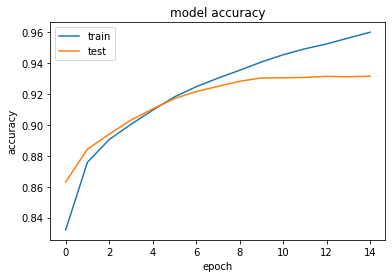

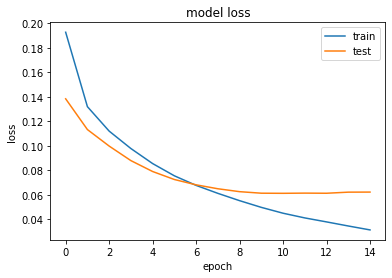

In [ ]:
plotHistory({
    'accuracy' : epoch_train_accuracy,
    'loss' : epoch_train_loss,
    'val_accuracy': epoch_val_accuracy,
    'val_loss': epoch_val_loss
})

### Evaluation Scores
This Block calculates the different Evaluation Score for the test set.

In [ ]:
REPS_FLAG=False

In [ ]:
score_df = None
if REPS_FLAG == True:
  score_df = pd.DataFrame(columns=['File_Name', 'ActualFinding', 'PredictedFinding', 'BLEU_1', 'BLEU_2', 'BLEU_3', 'BLEU_4', 'METEOR','ROUGE','CIDER'], index=range(0,len(test_data)))
else:
  # score_df_exp5.joblib is for experiment 6.
  score_df = load(base_path + '/ModelResults/score_df_exp5.joblib')

In [ ]:
score_df.columns

Index(['File_Name', 'ActualFinding', 'PredictedFinding', 'BLEU_1', 'BLEU_2',
       'BLEU_3', 'BLEU_4', 'METEOR', 'ROUGE', 'CIDER'],
      dtype='object')

In [ ]:
if REPS_FLAG == True:
  img_names = list(X_test.keys())
  img_reps = list(X_test.values())
  test_data = np.array(list(zip(img_reps,y_test)))
  # datagen_inference = DataGenerator(test_data,token,max_length=max_len,batch_size=1,shuffle=False)

  w_3g = 0.3333333333

  # Reading all the image in the test data
  for batch_num in tqdm.tqdm(range(0,len(test_data))):
    # X, y = datagen_inference.__getitem__(batch_num)

    # Predicting from the model
    X = test_data[batch_num, 0].reshape((1, 49, 1024))
    predicted_sent = inference_concat(X)
    predicted_sent = predicted_sent.split("<end>")[0]
    predicted_sent = predicted_sent.replace(' .', '.').strip()
    # Getting the actual and predicted sentences
    # print(y.shape)
    # actual_sent = token.sequences_to_texts(y)
    actual_sent = test_data[batch_num, 1].replace('<start>', '')
    actual_sent = actual_sent.replace('<end>', '').replace(' .', '.').strip()
    score_df.loc[batch_num, 'File_Name'] = img_names[batch_num]
    score_df.loc[batch_num, 'ActualFinding'] = actual_sent
    score_df.loc[batch_num, 'PredictedFinding'] = predicted_sent
    # print(actual_sent)
    # print(predicted_sent)
    # predicted_sent = token.sequences_to_texts(np.argmax(y_pred,axis = 1).reshape(1,len(y_pred)))
  # Converting the BLEU scores to numeric type
  dump(score_df,base_path + '/ModelResults/score_df_exp5.joblib')
'''
    # Calculating the Cumulative BLEU scores for
    # 1-Gram
    bleu_1 = sentence_bleu([actual_sent.split(" ")],predicted_sent.split(" "), weights=(1,0,0,0))
    # 2-Gram
    bleu_2 = sentence_bleu([actual_sent.split(" ")],predicted_sent.split(" "), weights=(0.5,0.5,0,0))
    # 3-Gram
    bleu_3 = sentence_bleu([actual_sent.split(" ")],predicted_sent.split(" "), weights=(w_3g,w_3g,w_3g,0))
    # 4-Gram
    bleu_4 = sentence_bleu([actual_sent.split(" ")],predicted_sent.split(" "), weights=(0.25,0.25,0.25,0.25))
    score_df.loc[batch_num, 'File_Name'] = img_names[batch_num]
    score_df.loc[batch_num, 'ActualFinding'] = actual_sent
    score_df.loc[batch_num, 'PredictedFinding'] = predicted_sent
    score_df.loc[batch_num, 'BLEU_1'] = bleu_1
    score_df.loc[batch_num, 'BLEU_2'] = bleu_2
    score_df.loc[batch_num, 'BLEU_3'] = bleu_3
    score_df.loc[batch_num, 'BLEU_4'] = bleu_4
'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
100%|██████████| 647/647 [01:58<00:00,  5.48it/s]


'\n    # Calculating the Cumulative BLEU scores for\n    # 1-Gram\n    bleu_1 = sentence_bleu([actual_sent.split(" ")],predicted_sent.split(" "), weights=(1,0,0,0))\n    # 2-Gram\n    bleu_2 = sentence_bleu([actual_sent.split(" ")],predicted_sent.split(" "), weights=(0.5,0.5,0,0))\n    # 3-Gram\n    bleu_3 = sentence_bleu([actual_sent.split(" ")],predicted_sent.split(" "), weights=(w_3g,w_3g,w_3g,0))\n    # 4-Gram\n    bleu_4 = sentence_bleu([actual_sent.split(" ")],predicted_sent.split(" "), weights=(0.25,0.25,0.25,0.25))\n    score_df.loc[batch_num, \'File_Name\'] = img_names[batch_num]\n    score_df.loc[batch_num, \'ActualFinding\'] = actual_sent\n    score_df.loc[batch_num, \'PredictedFinding\'] = predicted_sent\n    score_df.loc[batch_num, \'BLEU_1\'] = bleu_1\n    score_df.loc[batch_num, \'BLEU_2\'] = bleu_2\n    score_df.loc[batch_num, \'BLEU_3\'] = bleu_3\n    score_df.loc[batch_num, \'BLEU_4\'] = bleu_4\n'

In [ ]:
score_df['METEOR'] = 0.0
score_df['ROUGE'] = 0.0
score_df['CIDER'] = 0.0
# score_df['SPICE'] = 0.0

In [ ]:
score_df.head(5)

,File_Name,ActualFinding,PredictedFinding,BLEU_1,BLEU_2,BLEU_3,BLEU_4,METEOR,ROUGE,CIDER
0,CXR364_IM-1804-1001.png,the cardiomediastinal silhouette and pulmonary...,the heart is normal in size. the mediastinum i...,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,CXR3829_IM-1932-1001.png,stable moderate cardiomegaly. mediastinal cont...,the heart is normal in size. the mediastinum i...,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,CXR1645_IM-0422-1001.png,stable chronic appearing left basilar opacitie...,the heart is normal in size. the mediastinum i...,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,CXR2570_IM-1073-1001.png,there has been interval increase in size of th...,the heart is normal in size. the mediastinum i...,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,CXR1320_IM-0207-1001.png,calcified granuloma is noted in the left upper...,the heart size is normal. the mediastinal cont...,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [ ]:
candidate_sentences = {}
reference_sentences = {}
w_3g = 0.3333333333
for i in score_df.index:
  # actual_sentence = score_df.loc[i, "ActualFinding"]
  # predicted_sentence = score_df.loc[i, 'PredictedFinding']
  actual_sentence = score_df.loc[i, "ActualFinding"]
  predicted_sentence = score_df.loc[i, 'PredictedFinding']
  predicted_sentence = predicted_sentence.replace(' .', '.')

  actual_sentence = actual_sentence.replace('.', '')
  predicted_sentence = predicted_sentence.replace('.', '')

  # Calculating the Cumulative BLEU scores for
  # 1-Gram
  bleu_1 = sentence_bleu([actual_sentence.split(" ")],predicted_sentence.split(" "), weights=(1,0,0,0))
  # 2-Gram
  bleu_2 = sentence_bleu([actual_sentence.split(" ")],predicted_sentence.split(" "), weights=(0.5,0.5,0,0))
  # 3-Gram
  bleu_3 = sentence_bleu([actual_sentence.split(" ")],predicted_sentence.split(" "), weights=(w_3g,w_3g,w_3g,0))
  # 4-Gram
  bleu_4 = sentence_bleu([actual_sentence.split(" ")],predicted_sentence.split(" "), weights=(0.25,0.25,0.25,0.25))

  # METEOR
  #meteor = Meteor([actual_sentence.split(" ")],predicted_sentence.split(" "))
  meteor = round(meteor_score([actual_sentence],predicted_sentence), 2)

  #ROUGE
  rouge = Rouge()
  rouge_score = rouge.calc_score([predicted_sentence], [actual_sentence])
  image_id = score_df.loc[i, 'File_Name']

  candidate_sentences[image_id] = [predicted_sentence]
  reference_sentences[image_id] = [actual_sentence]

  # score_df.loc[i, "ActualFinding"] = actual_sentence
  # score_df.loc[i, 'PredictedFinding'] = predicted_sentence
  score_df.loc[i, 'BLEU_1'] = round(bleu_1 * 100.0, 4)
  score_df.loc[i, 'BLEU_2'] = round(bleu_2 * 100.0, 4)
  score_df.loc[i, 'BLEU_3'] = round(bleu_3 * 100.0, 4)
  score_df.loc[i, 'BLEU_4'] = round(bleu_4 * 100.0, 4)
  score_df.loc[i, 'METEOR'] = round(meteor * 100.0, 4)
  score_df.loc[i, 'ROUGE'] = round(rouge_score * 100.0, 4)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [ ]:
score_df.head(5)

,File_Name,ActualFinding,PredictedFinding,BLEU_1,BLEU_2,BLEU_3,BLEU_4,METEOR,ROUGE,CIDER
0,CXR364_IM-1804-1001.png,the cardiomediastinal silhouette and pulmonary...,the heart is normal in size. the mediastinum i...,18.2232,14.9506,12.1238,8.4781,22.0,34.1259,0.0
1,CXR3829_IM-1932-1001.png,stable moderate cardiomegaly. mediastinal cont...,the heart is normal in size. the mediastinum i...,4.5558,0,0,0,4.0,4.2657,0.0
2,CXR1645_IM-0422-1001.png,stable chronic appearing left basilar opacitie...,the heart is normal in size. the mediastinum i...,6.8472,0,0,0,6.0,11.6264,0.0
3,CXR2570_IM-1073-1001.png,there has been interval increase in size of th...,the heart is normal in size. the mediastinum i...,2.3177,0.9091,0,0,9.0,12.6978,0.0
4,CXR1320_IM-0207-1001.png,calcified granuloma is noted in the left upper...,the heart size is normal. the mediastinal cont...,48.9362,27.2888,17.0592,10.3064,41.0,27.6596,0.0


In [ ]:
cider = Cider()
cider_score = cider.compute_score(reference_sentences, candidate_sentences)

In [ ]:
cider_avg = cider_score[0]
# spice_avg = spice_score[0]

In [ ]:
for i in range(len(cider_score[1])):
  idx = score_df.index[i]
  score_df.loc[idx, 'CIDER'] = round(cider_score[1][i] * 10.0, 4)
  # score_df.loc[idx, 'SPICE'] = spice_score[1][i]['All']['f']

In [ ]:
score_df.sort_values(by='BLEU_4',ascending=False).head(10)

,File_Name,ActualFinding,PredictedFinding,BLEU_1,BLEU_2,BLEU_3,BLEU_4,METEOR,ROUGE,CIDER
584,CXR3183_IM-1502-1001.png,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,100,100,100,100,100.0,100.0000,100.000
61,CXR1259_IM-0175-1001.png,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,100,100,100,100,100.0,100.0000,100.000
264,CXR2423_IM-0965-1001.png,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,100,100,100,100,100.0,100.0000,100.000
159,CXR3663_IM-1822-1001.png,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,100,100,100,100,100.0,100.0000,100.000
579,CXR3325_IM-1591-1001.png,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,100,100,100,100,100.0,100.0000,100.000
161,CXR2017_IM-0665-1001.png,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,100,100,100,100,100.0,100.0000,100.000
562,CXR717_IM-2279-1001.png,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,100,100,100,100,100.0,100.0000,100.000
520,CXR3181_IM-1500-1001.png,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,100,100,100,100,100.0,100.0000,100.000
273,CXR2668_IM-1147-3001.png,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,100,100,100,100,100.0,100.0000,100.000
491,CXR1568_IM-0371-1001.png,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,86.6878,83.2869,81.9925,81.1843,88.0,92.2246,61.527


In [ ]:
unique_scores = score_df.loc[:,['ActualFinding', 'PredictedFinding', 'BLEU_1', 'BLEU_2', 'BLEU_3', 'BLEU_4', 'METEOR', 'ROUGE', 'CIDER']]
unique_scores = pd.DataFrame(unique_scores.value_counts().rename('Count')).reset_index()
unique_scores.sort_values(by='BLEU_4',ascending=False)

,ActualFinding,PredictedFinding,BLEU_1,BLEU_2,BLEU_3,BLEU_4,METEOR,ROUGE,CIDER,Count
1,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,100.0000,100.0000,100.0000,100.0000,100.0,100.0000,100.0000,9
506,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,86.6878,83.2869,81.9925,81.1843,88.0,92.2246,61.5270,1
517,the heart is top normal in size. the mediastin...,the heart is normal in size. the mediastinum i...,93.1063,89.4536,85.3096,80.5225,94.0,95.9551,55.0285,1
495,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,92.8571,88.6405,83.8382,78.2542,93.0,92.8571,52.8223,1
502,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,58.8235,57.5224,56.0907,54.5018,52.0,65.6620,56.2563,1
...,...,...,...,...,...,...,...,...,...,...
189,cardiomediastinal silhouettes are within norma...,the heart is normal in size. the mediastinum i...,6.2295,3.7324,2.5649,0.0000,13.0,13.3625,0.0000,1
187,chest stable cardiomediastinal silhouette. pul...,the heart is normal in size and contour. there...,15.3440,6.3835,0.0000,0.0000,12.0,15.1968,0.0544,1
186,heart size and mediastinal contours appear wit...,the heart is normal in size and contour. there...,38.3246,15.9440,0.0000,0.0000,30.0,27.2473,2.9103,1
185,heart size and mediastinal contour within norm...,the heart is normal in size. the mediastinum i...,12.1011,0.0000,0.0000,0.0000,7.0,10.6830,0.3198,1


In [ ]:
img_name = 'CXR2565_IM-1068-1002.png'
print('Actual Finding: ' + score_df[score_df['File_Name'] == img_name].reset_index()['ActualFinding'][0])
print('Predicted Finding: ' + score_df[score_df['File_Name'] == img_name].reset_index()['PredictedFinding'][0])

Actual Finding: the heart is normal in size. the aorta is tortuous. the lungs are hypoinflated. no focal consolidation or pleural effusion seen. old rightsided rib fracture is noted.
Predicted Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.


In [ ]:
dump(score_df,base_path + '/ModelResults/score_df_exp5.joblib')

['/content/gdrive/My Drive/Colab Notebooks/Image_captioning_capstone/ModelResults/score_df_exp5.joblib']

In [ ]:
# Top 5 best predictions (Based on Cumulative BLUE-4)
def print_inferences(unique_scores_subset, includeBest):
  imgNo=1
  for idx in unique_scores_subset.index:
    main_idx = 0
    if includeBest == True:
      main_idx = score_df[score_df['ActualFinding'] == unique_scores_subset.loc[idx, 'ActualFinding']].sort_values(by='BLEU_4', ascending=False).index[0]
    else:
      main_idx = score_df[score_df['ActualFinding'] == unique_scores_subset.loc[idx, 'ActualFinding']].sort_values(by='BLEU_4', ascending=True).index[0]
    print('{}. Image: {}'.format(imgNo, score_df.loc[main_idx, 'File_Name']))
    imgNo+=1
    # Get the image and show it
    image_data = imread(base_path + '/Images/' + score_df.loc[main_idx, 'File_Name'], IMREAD_COLOR)
    resized_image = np.array(resize(image_data, (299, 299)))
    imgPlot = plt.imshow(resized_image)
    plt.show()

    # Printing the actual and Predicted Findings
    print('Actual Finding: {}'.format(score_df.loc[main_idx, 'ActualFinding']))
    print('Predicted Finding: {}'.format(score_df.loc[main_idx, 'PredictedFinding']))

    # Printing the BLEU scores
    print('BLEU-1 Score: {}'.format(score_df.loc[main_idx, 'BLEU_1']))
    print('BLEU-2 Score: {}'.format(score_df.loc[main_idx, 'BLEU_2']))
    print('BLEU-3 Score: {}'.format(score_df.loc[main_idx, 'BLEU_3']))
    print('BLEU-4 Score: {}'.format(score_df.loc[main_idx, 'BLEU_4']))
    print('METEOR Score: {}'.format(score_df.loc[main_idx, 'METEOR']))
    print('ROUGE Score: {}'.format(score_df.loc[main_idx, 'ROUGE']))
    print('CIDER Score: {}'.format(score_df.loc[main_idx, 'CIDER']))

The following are the Top 5 best predictions made by the model (Based on the Cumulative 4-Gram BLEU score)
1. Image: CXR1259_IM-0175-1001.png


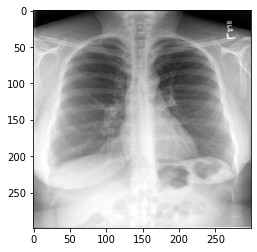

Actual Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Predicted Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
BLEU-1 Score: 100.0
BLEU-2 Score: 100.0
BLEU-3 Score: 100.0
BLEU-4 Score: 100.0
METEOR Score: 100.0
ROUGE Score: 100.0
CIDER Score: 100.0
2. Image: CXR1568_IM-0371-1001.png


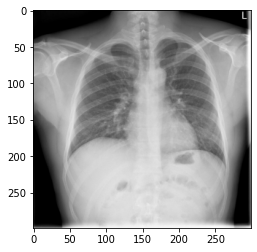

Actual Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are hypoinflated but clear.
Predicted Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
BLEU-1 Score: 86.6878
BLEU-2 Score: 83.2869
BLEU-3 Score: 81.9925
BLEU-4 Score: 81.1843
METEOR Score: 88.0
ROUGE Score: 92.2246
CIDER Score: 61.527
3. Image: CXR1011_IM-0013-1001.png


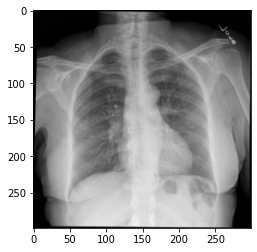

Actual Finding: the heart is top normal in size. the mediastinum is unremarkable. the lungs are clear.
Predicted Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
BLEU-1 Score: 93.1063
BLEU-2 Score: 89.4536
BLEU-3 Score: 85.3096
BLEU-4 Score: 80.5225
METEOR Score: 94.0
ROUGE Score: 95.9551
CIDER Score: 55.0285
4. Image: CXR354_IM-1731-1001.png


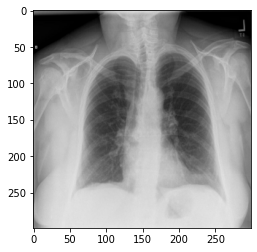

Actual Finding: the heart is normal in size. the mediastinum is stable. the lungs are clear.
Predicted Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
BLEU-1 Score: 92.8571
BLEU-2 Score: 88.6405
BLEU-3 Score: 83.8382
BLEU-4 Score: 78.2542
METEOR Score: 93.0
ROUGE Score: 92.8571
CIDER Score: 52.8223
5. Image: CXR1259_IM-0175-1001.png


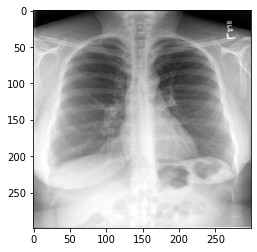

Actual Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Predicted Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
BLEU-1 Score: 100.0
BLEU-2 Score: 100.0
BLEU-3 Score: 100.0
BLEU-4 Score: 100.0
METEOR Score: 100.0
ROUGE Score: 100.0
CIDER Score: 100.0


In [ ]:
n = 5
print('The following are the Top {} best predictions made by the model (Based on the Cumulative 4-Gram BLEU score)'.format(n))
print_inferences(unique_scores.sort_values(['BLEU_4'], axis=0, ascending=False).head(n), True)

The following are the Top 5 poor predictions made by the model (Based on the Cumulative 4-Gram BLEU score)
1. Image: CXR342_IM-1655-0001-0001.png


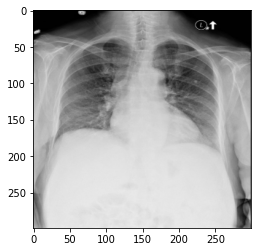

Actual Finding: the lungs and pleural spaces show no acute abnormality. stable left upper lobe calcified granuloma. heart size is mildly enlarged pulmonary vascularity within normal limits. mild tortuosity of the descending thoracic aorta.
Predicted Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
BLEU-1 Score: 13.8227
BLEU-2 Score: 5.4217
BLEU-3 Score: 0.0
BLEU-4 Score: 0.0
METEOR Score: 12.0
ROUGE Score: 20.3063
CIDER Score: 0.0122
2. Image: CXR3384_IM-1631-1001.png


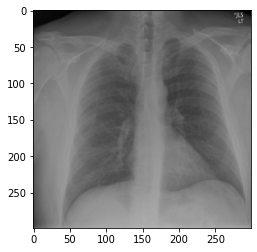

Actual Finding: both lungs are clear and expanded. heart and mediastinum normal.
Predicted Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
BLEU-1 Score: 42.8571
BLEU-2 Score: 25.6776
BLEU-3 Score: 17.6459
BLEU-4 Score: 0.0
METEOR Score: 49.0
ROUGE Score: 25.7746
CIDER Score: 6.0466
3. Image: CXR2362_IM-0926-1001.png


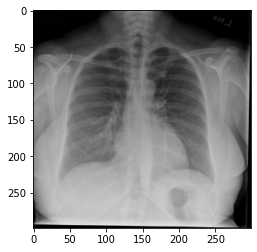

Actual Finding: lungs are clear bilaterally. cardiac and mediastinal silhouettes are normal. pulmonary vasculature is normal. no pneumothorax or pleural effusion. no acute bony abnormality.
Predicted Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
BLEU-1 Score: 18.7781
BLEU-2 Score: 15.0946
BLEU-3 Score: 9.9944
BLEU-4 Score: 0.0
METEOR Score: 11.0
ROUGE Score: 15.5348
CIDER Score: 0.9057
4. Image: CXR82_IM-2350-3001.png


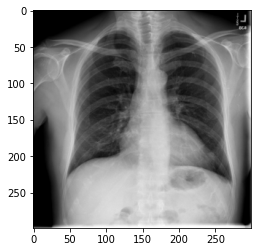

Actual Finding: no airspace disease effusion or noncalcified nodule. normal heart size and mediastinum. left axillary surgical clips unchanged visualized of the chest are within normal limits.
Predicted Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
BLEU-1 Score: 19.534
BLEU-2 Score: 0.0
BLEU-3 Score: 0.0
BLEU-4 Score: 0.0
METEOR Score: 13.0
ROUGE Score: 24.4
CIDER Score: 0.4526
5. Image: CXR3155_IM-1486-1001.png


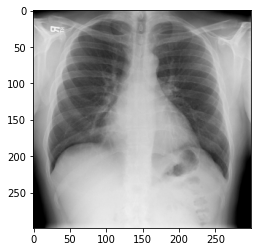

Actual Finding: heart size mildly enlarged with enlarged right atrium. no focal alveolar consolidation no definite pleural effusion seen. no pneumothorax.
Predicted Finding: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
BLEU-1 Score: 9.9953
BLEU-2 Score: 0.0
BLEU-3 Score: 0.0
BLEU-4 Score: 0.0
METEOR Score: 5.0
ROUGE Score: 11.7988
CIDER Score: 0.2717


In [ ]:
print('The following are the Top {} poor predictions made by the model (Based on the Cumulative 4-Gram BLEU score)'.format(n))
print_inferences(score_df.sort_values(['BLEU_4'], axis=0).head(n), False)

In [ ]:
print('The Average Evaluation Scores are')
score_df.mean()

The Average Evaluation Scores are


BLEU_1    23.356438
BLEU_2    13.479570
BLEU_3     9.167815
BLEU_4     5.594946
METEOR    21.870170
ROUGE     25.135551
CIDER      3.126848
dtype: float64

In [ ]:
unique_scores = score_df.loc[:,['ActualFinding', 'PredictedFinding', 'BLEU_1', 'BLEU_2', 'BLEU_3', 'BLEU_4']]
unique_scores = pd.DataFrame(unique_scores.value_counts().rename('Count')).reset_index()
unique_scores.sort_values(by='BLEU_4',ascending=False)

,ActualFinding,PredictedFinding,BLEU_1,BLEU_2,BLEU_3,BLEU_4,Count
1,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,100.0000,100.0000,100.0000,100.0000,9
506,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,86.6878,83.2869,81.9925,81.1843,1
517,the heart is top normal in size. the mediastin...,the heart is normal in size. the mediastinum i...,93.1063,89.4536,85.3096,80.5225,1
495,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,92.8571,88.6405,83.8382,78.2542,1
502,the heart is normal in size. the mediastinum i...,the heart is normal in size. the mediastinum i...,58.8235,57.5224,56.0907,54.5018,1
...,...,...,...,...,...,...,...
189,cardiomediastinal silhouettes are within norma...,the heart is normal in size. the mediastinum i...,6.2295,3.7324,2.5649,0.0000,1
187,chest stable cardiomediastinal silhouette. pul...,the heart is normal in size and contour. there...,15.3440,6.3835,0.0000,0.0000,1
186,heart size and mediastinal contours appear wit...,the heart is normal in size and contour. there...,38.3246,15.9440,0.0000,0.0000,1
185,heart size and mediastinal contour within norm...,the heart is normal in size. the mediastinum i...,12.1011,0.0000,0.0000,0.0000,1


In [ ]:
# avg_b4s - Average BLEU_4 Score
avg_b4s = unique_scores['BLEU_4'].mean()
score_cnt = score_df.shape[0]
# npaab4s - number of predictions above average BLEU_4 score
npaab4s = score_df[score_df['BLEU_4'] >= avg_b4s].count()[0]

# npbab4s - number of predictions below a
npbab4s = score_cnt - npaab4s
print('There are {} ({} %) predictions having BLEU-4 Score above the Average of {}.'.format(npaab4s, round(npaab4s / score_cnt *100, 1), round(avg_b4s, 4)))
print('There are {} ({} %) predictions having BLEU-4 Score Below the Average of {}.'.format(npbab4s, round(npbab4s / score_cnt *100, 1), round(avg_b4s, 4)))

There are 180 (27.8 %) predictions having BLEU-4 Score above the Average of 4.3674.
There are 467 (72.2 %) predictions having BLEU-4 Score Below the Average of 4.3674.


In [ ]:
bleu_4 = score_df["BLEU_4"]

In [ ]:
import seaborn as sns

In [ ]:
def plotCategoricalCounts(columnSeries, xTitle):
    ax = sns.histplot(columnSeries, bins=[0,20,40,60,80,100])
    # for p in ax.patches:
    #     ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    ax.set(xlabel=xTitle, ylabel='Count')
    # ymax = columnSeries.value_counts().max() + 60
    # ax.set(ylim=(0,ymax))
    plt.show()

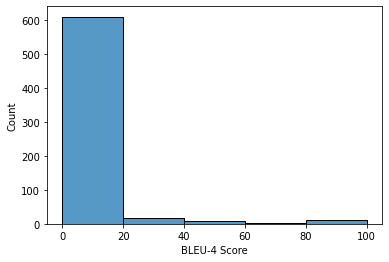

In [ ]:
plotCategoricalCounts(bleu_4, 'BLEU-4 Score')